### 0.导入函数库

In [2]:
%matplotlib inline
from scipy import signal
from obspy.signal.invsim import cosine_taper 
from matplotlib import rcParams
import numpy as np
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = 15, 3

### 傅里叶变换

傅里叶变换是基于傅里叶级数的。通过傅里叶级数，我们可以用一系列由一些系数加权的基函数的求和来近似一个函数 f(x)。基函数需要是正交的。正弦和余弦函数似乎是一个很好的选择，因为任何信号都可以被滤波成几个正弦波。在周期范围 [−T/2;T/2] 内，傅里叶级数定义为：
  
$$ f(t)\approx{g_n(t)}=\frac{1}{2}a_0+\sum^{N}_{k=1}\left[a_k{cos\left(\frac{2\pi{kt}}{T}\right)}+{b_k}sin\left(\frac{2\pi{kt}}{T}\right)\right] $$
 
$$ a_k=\frac{2}{T}\int_{-\frac{T}{2}}^\frac{T}{2}{f(t)}{cos\left(\frac{2\pi{kt}}{T}\right)}dt $$
 
$$ b_k=\frac{2}{T}\int_{-\frac{T}{2}}^\frac{T}{2}{f(t)}{sin\left(\frac{2\pi{kt}}{T}\right)}dt $$
 
对于非周期函数，周期性的区间趋向于无穷大。因此傅里叶级数的无穷和变成了积分，我们最终得到了傅里叶变换的积分形式：

$$ f(t)={\int^{\infty}_{−\infty}}F(\omega)e^{i{\omega}t}dt $$

在地震学中，我们没有连续的时间信号，而是离散的。因此，我们使用离散形式的傅里叶变换：

$$ f_k=\sum^{N-1}_{j=1}F_j{e^{2{\pi}ikj/N}} $$


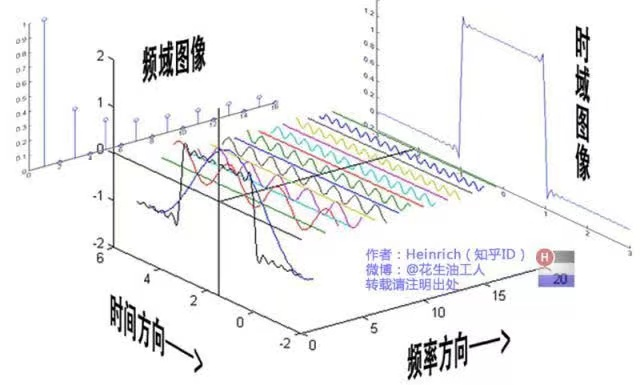

### 1.傅里叶级数和系数

In [3]:
# 计算给定函数的傅里叶级数的系数

def fourier_series_coeff(f, T, N):
    """
    计算周期函数的前2*N+1个傅里叶级数系数。
    
    Parameters
    f: 周期函数, 类似于f(t)的可调用对象
    T: 函数f的周期, 使得f(0)==f(T)
    N: 函数将返回前N + 1个傅里叶系数。

    Returns
    a0: 浮点数
    a, b: numpy浮点数组, 分别描述余弦和正弦系数。
    """
    # 在周期T内对f进行采样的点数。
    # 根据奈奎斯特定理，信号的采样频率，要等于大于想在信号中捕获的最大频率的2倍。 
    f_sample = 2 * N
    
    t, dt = np.linspace(0, T, f_sample + 2, endpoint=False, retstep=True)
    y = np.fft.rfft(f) / t.size
    y *= 2
    return y[0].real, y[1:-1].real[0:N], -y[1:-1].imag[0:N]

# 根据给定的系数和加权因子创建一个函数
def series_real_coeff(a0, a, b, t, T):
    """
    计算傅里叶级数
    """
    tmp = np.ones_like(t) * a0 / 2.
    for k, (ak, bk) in enumerate(zip(a, b)):
        tmp += ak * np.cos(2 * np.pi * (k + 1) * t / T) + bk * np.sin(
            2 * np.pi * (k + 1) * t / T)
    return tmp

### 2.创建周期性的离散有限信号

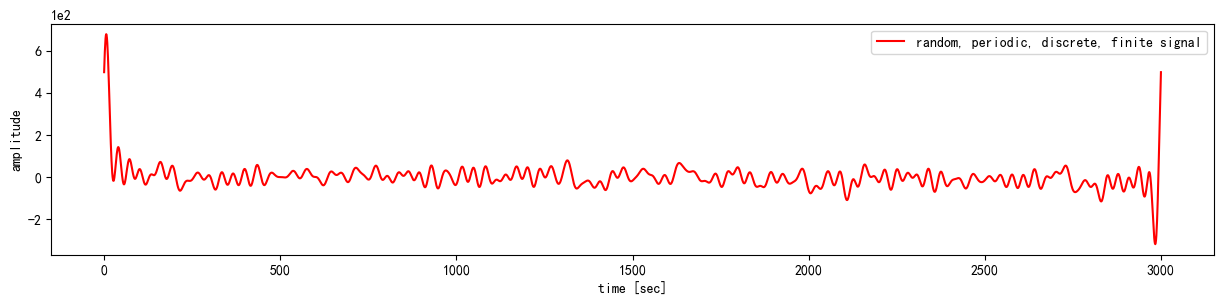

In [4]:
samp = 3000      # 样本数
dt = 1           # 采样率
T = 1.0 / dt     # 周期
length = samp * dt
N = 100          # 系数数量（初始值：100）

# 系数的加权因子（随机选择）
a0 = np.random.rand(1)
a = np.random.randint(1, high=11, size=N)
b = np.random.randint(1, high=11, size=N)

t = np.linspace(0, length, samp)             # 时间轴
sig = series_real_coeff(a0, a, b, t, T)

# 绘图
plt.plot(t, sig, 'r', label='random, periodic, discrete, finite signal')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
plt.xlabel('time [sec]')
plt.ylabel('amplitude')
plt.legend()
plt.show()

### 3.计算函数的前n个系数

coefficient a0 =  85
array coefficients ak = [ 319  864  592 1277 1409  599 1279 1416  861  869]
array coefficients bk = [1364  410  275  955  273 1368  816 1221  134  816]


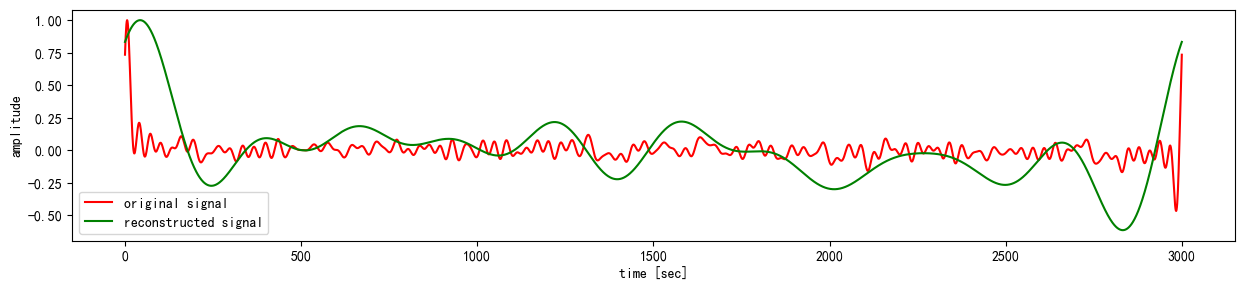

In [5]:
T = 1        # 周期
n = 10        # 要重构的系数数量
a0, a, b = fourier_series_coeff(sig, T, n)
a_ = a.astype(int)
b_ = b.astype(int)
print('coefficient a0 = ', int(a0))
print('array coefficients ak =', a_)
print('array coefficients bk =', b_)

# 重构函数
g = series_real_coeff(a0, a, b, t, dt)

# 绘图
#plt.plot(t, sig, 'b', label='original signal')           # 没有归一化
#plt.plot(t, g, 'y', label='reconstructed signal')
plt.plot(t, sig/max(sig), 'r', label='original signal')   # 归一化 
plt.plot(t, g/max(g), 'g', label='reconstructed signal')

plt.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
plt.xlabel('time [sec]')
plt.ylabel('amplitude')
plt.legend()
plt.show()

### 4.傅里叶变换信号

Text(0, 0.5, 'Amplitude')

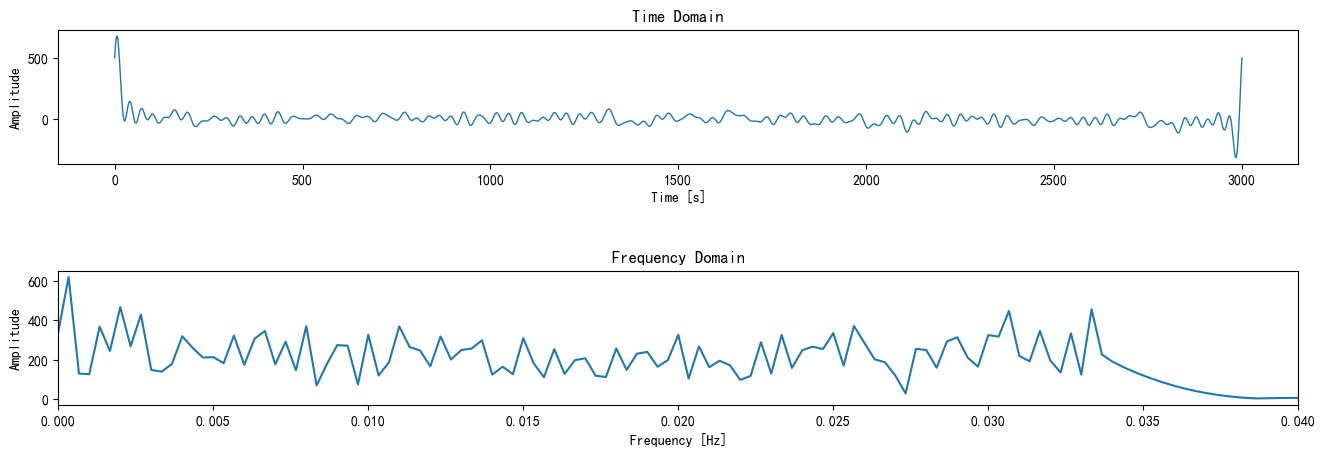

In [6]:
taper_percentage = 0.1      # 应用于信号的锥度百分比（初始值：0.1）
npts = 50                  
taper = cosine_taper(samp,taper_percentage)

sig_ = sig * taper
Fsig = np.fft.rfft(sig_, n=samp)
xf = np.linspace(0.0, 1.0/(2.0*T), int((samp/2)+1))

# 绘图
rcParams["figure.subplot.hspace"] = (0.8)
rcParams["figure.figsize"] = (16, 8)
plt.subplot(311)
plt.title('Time Domain')
plt.plot(t, sig, linewidth=1)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(312)
plt.title('Frequency Domain')
plt.plot(xf, 2.0/npts * np.abs(Fsig))
plt.xlim(0, 0.04)                                
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')